In [1]:
working_directory = '/mnt/DataRAID/melismail/PDAC'
import os
os.chdir(working_directory)
from pickle_utils import write_pickle, read_pickle

import sys, cv2, math
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from os import listdir 
from os.path import isfile, join
from numpy import argmax
from tifffile import imread, imsave
from glob import glob

import sklearn
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, preprocessing
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report
from scikitplot.metrics import plot_roc, plot_precision_recall, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

np.random.seed(109)

In [2]:
#MaxNumber of kernels on the workstation
len(os.sched_getaffinity(0))

28

In [3]:
base_path = '/mnt/DataRAID/melismail/PDAC/data'
preprocessing_path ='Preprocessing_mask_annotation'
model_path = 'VGG-16' #ResNet50 #InceptionV3
clustering_path = 'Classification'
plot_path = 'plots/Classification' 
class_path = 'two_classes/celltypes' #masks

In [4]:
df_dataset = read_pickle(path=os.path.join(base_path, preprocessing_path, model_path, f"{model_path}_celltypes_lbl_df.pkl"))

In [5]:
print(df_dataset.head())

   Pseudonym  tile_id    lbl_mask  Acinar cells  Alpha cells  B cells  Basal  \
0  IAA2LDX17  (1, 23)  non-cancer           0.0          0.0      0.0    0.0   
1  IAA2LDX17  (1, 27)  non-cancer           0.0          0.0      1.0    2.0   
2  IAA2LDX17  (1, 28)  non-cancer           0.0          0.0      1.0    1.0   
3  IAA2LDX17  (1, 29)  non-cancer           1.0          0.0      0.0    1.0   
4  18QH2FGR4  (2, 17)  non-cancer           0.0          0.0      0.0    0.0   

   Beta cells  Classical_CEACAM  Classical_KRT7  ...  NK cells  Schwann cells  \
0         0.0               1.0             2.0  ...       0.0            0.0   
1         0.0               8.0             0.0  ...       0.0            0.0   
2         1.0              12.0             0.0  ...       2.0            1.0   
3         0.0               2.0             0.0  ...       0.0            0.0   
4         0.0               0.0             0.0  ...       0.0            0.0   

   T cells  iCAF  myCAF_ACTA2  m

In [6]:
X = df_dataset["Features"].to_list()
y = df_dataset["lbl"] #lbl_mask

In [7]:
y_dic = {idx: i for idx, i in enumerate(np.unique(y))}
classes = sorted(y_dic.items(), key=lambda item: item[0])
classes = [i[1] for i in classes]
print(y_dic)
print(classes)

{0: 'cancer', 1: 'non-cancer'}
['cancer', 'non-cancer']


In [8]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(y)

[0 0 0 ... 0 1 1]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({1: 5756, 0: 1636})
Testing target statistics: Counter({1: 1434, 0: 414})


In [10]:
def build_and_test(X_tr, X_te, y_tr, y_te, plot_dir:str, model_name:str, parameter:dict, scaler:str, balancer:str, cv: int):
    print( model_name, scaler, balancer, parameter, cv)

    direct = os.path.join(plot_dir, model_name, scaler, balancer) 
    os.makedirs(direct, exist_ok=True)

    model_dir = os.path.join(base_path, clustering_path, class_path, model_path, model_name, scaler, balancer)
    os.makedirs(direct, exist_ok=True)

    target_file = os.path.join(model_dir, f"Classifier_{cv}.pkl")
    if os.path.isfile(target_file):
                               return read_pickle(target_file)
                               
    #scale data
    if scaler == 'StandardScaler':
        std_scaler = StandardScaler().fit(X_tr + X_te)
        X_tr_scaled = std_scaler.transform(X_tr)
        X_te_scaled = std_scaler.transform(X_te)
    elif scaler == 'MinMaxScaler':
        minmax_scaler = MinMaxScaler().fit(X_tr + X_te)
        X_tr_scaled = minmax_scaler.transform(X_tr)
        X_te_scaled = minmax_scaler.transform(X_te)
    else:
        X_tr_scaled = X_tr
        X_te_scaled = X_te
    
    
    #balance dataset
    if balancer == 'RandomOversampler':
        over_sampler = RandomOverSampler(random_state=109)
        X_tr_sampled, y_tr_sampled = over_sampler.fit_resample(X_tr_scaled, y_tr)
    elif balancer == 'RandomUndersampler':
        under_sampler = RandomUnderSampler(random_state=109)
        X_tr_sampled, y_tr_sampled = under_sampler.fit_resample(X_tr_scaled, y_tr)
    else:
        X_tr_sampled, y_tr_sampled = X_tr_scaled, y_tr
    
    
    #build model
    if model_name == 'SVM':
        parameters = parameter
        grid = GridSearchCV(svm.SVC(probability=True), param_grid = parameters, n_jobs = -1, refit=True, verbose=2, cv=cv)
        grid.fit(X_tr_sampled, y_tr_sampled)
        print(grid.best_params_)
        model = svm.SVC(probability=True, **grid.best_params_)
        model.fit(X_tr_sampled, y_tr_sampled)
        y_pred = model.predict(X_te_scaled)
    elif model_name == 'LogisticRegression':
        parameters = parameter
        grid = GridSearchCV(LogisticRegression(max_iter=2500), param_grid = parameters, n_jobs = -1, refit=True, verbose=2, cv=cv)
        grid.fit(X_tr_sampled, y_tr_sampled)
        model = LogisticRegression(max_iter=2500, **grid.best_params_)
        model.fit(X_tr_sampled, y_tr_sampled)
        y_pred = model.predict(X_te_scaled)
    elif model_name == 'RandomForest':
        parameters = parameter
        grid = GridSearchCV(RandomForestClassifier(), param_grid = parameters, n_jobs = -1, refit=True, verbose=3, cv=cv)
        grid.fit(X_tr_sampled, y_tr_sampled)
        model = RandomForestClassifier(**grid.best_params_)
        model.fit(X_tr_sampled, y_tr_sampled)
        y_pred = model.predict(X_te_scaled)
    else:
        print(f'WARNING no {model} model found!')


    
    y_score = model.predict_proba(X_te_scaled)
    fpr0, tpr0, thresholds = roc_curve(y_te, y_score[:, 1])
    roc_auc0 = auc(fpr0, tpr0)
                   
    #print metrices    
    result_dic = {f'Model Name': model_name,
                  "Model": model,
                  f'Balancer': balancer,
                  f'Scaler': scaler,
                  "Cross-Validation Folds": cv,
                  f'Precision score': precision_score(y_te, y_pred),
                  f'Recall score':  recall_score(y_te, y_pred),
                  f'F1-score score': f1_score(y_te, y_pred),
                  f'Accuracy score': accuracy_score(y_te, y_pred),
                  f'Area under the ROC curve (AUC)': roc_auc0,
                  f'Grid_param': grid.best_params_,
                  'cm': confusion_matrix(y_te, y_pred),
                  'classification_report': classification_report(y_te, y_pred),
                  "y_score": y_score, "y_test": y_te, "y_pred": y_pred}
    
    print(model_name, balancer, scaler)
    try:
        # Plot metrics 
        #plot_roc(y_te,  y_score[:, 1])
        plt.plot(fpr0, tpr0)
        plt.title(f'ROC curve of \n model:{model} scaler:{scaler} \n balancer:{balancer}')
        plt.tight_layout()
        plt.savefig(os.path.join(direct, 'roc.png'))
        plt.clf()
        plt.close()


        plot_precision_recall(y_te, y_score)
        plt.title(f'Precision Recall curve of \n model:{model} scaler:{scaler} \n balancer:{balancer}')
        plt.tight_layout()
        plt.savefig(os.path.join(direct, 'precision_recall.png'))
        plt.clf()
        plt.close()

        plot_confusion_matrix(y_te, y_pred, cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix of \n model:{model} scaler:{scaler} \n balancer:{balancer}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig(os.path.join(direct, 'Confusion_Matrix.png'))
        plt.clf()
        plt.close()
        
    except Exception as e:
        print("\n\n\n Error")
        print(e)
        print(len(y_score), len(y_pred), len(y_te))

        print(y_score)
        print(y_pred)
        print(y_te)

        print("\n\n\n")

    write_pickle(path=target_file, obj=result_dic)
    return result_dic 

In [ ]:
balancer_list = ['RandomOversampler', 'RandomUndersampler', '']
scaler_list = ['MinMaxScaler', 'StandardScaler', '']
ml_model_list = ['SVM', 'LogisticRegression', 'RandomForest']
parameter_list = [{'C':[0.1, 1] , 'kernel':('linear', 'poly'), 'class_weight':('', 'balanced')},
                  {'penalty':('none', 'l2'), 'C':[0.1, 1], 'class_weight':('', 'balanced'), 'solver':('lbfgs', 'sag')},
                  {'n_estimators':[100, 500], 'min_samples_split':[2, 5], 'bootstrap':[True, False]}]
cv_list = [5]
classification_dic = read_pickle(path= os.path.join(base_path, clustering_path, class_path, model_path, f"{model_path}_classification_dict.pkl"))
if classification_dic is not None:
    already_done_set = {(class_dict["model_name"], class_dict["scaler"],  class_dict["balancer"],  class_dict["Cross-Validation Folds"])for class_dict in classification_dic}
else:
    already_done_set = set()
    classification_dic = []

new_classification_dict_list =[build_and_test(X_tr=X_train, X_te=X_test, y_tr=y_train, y_te=y_test, 
                                      plot_dir=os.path.join(base_path, plot_path, class_path, model_path), 
                                      model_name = m, scaler=s, balancer=b, parameter=p, cv=c)
                       for s in scaler_list
                       for b in balancer_list
                       for m, p in zip(ml_model_list, parameter_list)
                       for c in cv_list
                           if (m,s,b,c) not in already_done_set]

if len(new_classification_dict_list) > 0:
    classification_dic.extend(new_classification_dict_list)
    write_pickle(path= os.path.join(base_path, clustering_path, class_path, model_path, f"{model_path}_classification_dict.pkl"), obj=classification_dic)

In [12]:
df_classification = pd.DataFrame(classification_dic)
df_classification

,Model Name,Model,Balancer,Scaler,Cross-Validation Folds,Precision score,Recall score,F1-score score,Accuracy score,Area under the ROC curve (AUC),Grid_param,cm,classification_report,y_score,y_test,y_pred
0,SVM,"SVC(C=1, class_weight='', kernel='poly', proba...",RandomOversampler,MinMaxScaler,5,0.815120,0.759414,0.786282,0.679654,0.628813,"{'C': 1, 'class_weight': '', 'kernel': 'poly'}","[[167, 247], [345, 1089]]",precision recall f1-score ...,"[[0.4089462635571268, 0.5910537364428731], [0....","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, ..."
1,LogisticRegression,"LogisticRegression(C=0.1, class_weight='', max...",RandomOversampler,MinMaxScaler,5,0.801024,0.763598,0.781864,0.669372,0.564546,"{'C': 0.1, 'class_weight': '', 'penalty': 'non...","[[142, 272], [339, 1095]]",precision recall f1-score ...,"[[2.6645352591003757e-15, 0.9999999999999973],...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, ..."
2,RandomForest,"(DecisionTreeClassifier(max_features='sqrt', r...",RandomOversampler,MinMaxScaler,5,0.776030,0.997908,0.873093,0.774892,0.651822,"{'bootstrap': False, 'min_samples_split': 2, '...","[[1, 413], [3, 1431]]",precision recall f1-score ...,"[[0.188, 0.812], [0.204, 0.796], [0.184, 0.816...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,SVM,"SVC(C=0.1, class_weight='balanced', kernel='li...",RandomUndersampler,MinMaxScaler,5,0.826176,0.563459,0.669983,0.569264,0.621196,"{'C': 0.1, 'class_weight': 'balanced', 'kernel...","[[244, 170], [626, 808]]",precision recall f1-score ...,"[[0.5, 0.5], [0.7722407568422323, 0.2277592431...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, ..."
4,LogisticRegression,"LogisticRegression(C=0.1, class_weight='', max...",RandomUndersampler,MinMaxScaler,5,0.836510,0.581590,0.686137,0.587121,0.634720,"{'C': 0.1, 'class_weight': '', 'penalty': 'l2'...","[[251, 163], [600, 834]]",precision recall f1-score ...,"[[0.518696992971669, 0.48130300702833095], [0....","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, ..."
5,RandomForest,"(DecisionTreeClassifier(max_features='sqrt', r...",RandomUndersampler,MinMaxScaler,5,0.845416,0.552999,0.668634,0.574675,0.645703,"{'bootstrap': True, 'min_samples_split': 2, 'n...","[[269, 145], [641, 793]]",precision recall f1-score ...,"[[0.422, 0.578], [0.576, 0.424], [0.484, 0.516...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, ..."
6,SVM,"SVC(C=0.1, class_weight='', kernel='poly', pro...",,MinMaxScaler,5,0.775974,1.000000,0.873857,0.775974,0.612358,"{'C': 0.1, 'class_weight': '', 'kernel': 'poly'}","[[0, 414], [0, 1434]]",precision recall f1-score ...,"[[0.20440630712352884, 0.795593692876471], [0....","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7,LogisticRegression,"LogisticRegression(C=0.1, class_weight='', max...",,MinMaxScaler,5,0.781838,0.984658,0.871605,0.774892,0.649198,"{'C': 0.1, 'class_weight': '', 'penalty': 'l2'...","[[20, 394], [22, 1412]]",precision recall f1-score ...,"[[0.2415646575142001, 0.7584353424857999], [0....","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
8,RandomForest,"(DecisionTreeClassifier(max_features='sqrt', r...",,MinMaxScaler,5,0.779716,0.997211,0.875153,0.779221,0.633720,"{'bootstrap': True, 'min_samples_split': 2, 'n...","[[10, 404], [4, 1430]]",precision recall f1-score ...,"[[0.204, 0.796], [0.42, 0.58], [0.156, 0.844],...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9,SVM,"SVC(C=1, class_weight='', kernel='linear', pro...",RandomOversampler,StandardScaler,5,0.803179,0.739888,0.770236,0.657468,0.584770,"{'C': 1, 'class_weight': '', 'kern

In [13]:
df_classification["Model Name"] = df_classification.apply(lambda row: type(row["Model"]).__name__, axis=1)
df_classification.sort_values(by="F1-score score").reset_index(drop=True)

,Model Name,Model,Balancer,Scaler,Cross-Validation Folds,Precision score,Recall score,F1-score score,Accuracy score,Area under the ROC curve (AUC),Grid_param,cm,classification_report,y_score,y_test,y_pred
0,SVC,"SVC(C=1, class_weight='', kernel='poly', proba...",RandomUndersampler,,5,0.849945,0.541144,0.661270,0.569805,0.643492,"{'C': 1, 'class_weight': '', 'kernel': 'poly'}","[[277, 137], [658, 776]]",precision recall f1-score ...,"[[0.5317144888554299, 0.4682855111445701], [0....","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, ..."
1,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', r...",RandomUndersampler,StandardScaler,5,0.843918,0.546722,0.663563,0.569805,0.652135,"{'bootstrap': True, 'min_samples_split': 2, 'n...","[[269, 145], [650, 784]]",precision recall f1-score ...,"[[0.444, 0.556], [0.6, 0.4], [0.466, 0.534], [...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, ..."
2,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', r...",RandomUndersampler,MinMaxScaler,5,0.845416,0.552999,0.668634,0.574675,0.645703,"{'bootstrap': True, 'min_samples_split': 2, 'n...","[[269, 145], [641, 793]]",precision recall f1-score ...,"[[0.422, 0.578], [0.576, 0.424], [0.484, 0.516...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, ..."
3,SVC,"SVC(C=0.1, class_weight='balanced', kernel='li...",RandomUndersampler,MinMaxScaler,5,0.826176,0.563459,0.669983,0.569264,0.621196,"{'C': 0.1, 'class_weight': 'balanced', 'kernel...","[[244, 170], [626, 808]]",precision recall f1-score ...,"[[0.5, 0.5], [0.7722407568422323, 0.2277592431...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, ..."
4,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', r...",RandomUndersampler,,5,0.838174,0.563459,0.673895,0.576840,0.643850,"{'bootstrap': False, 'min_samples_split': 2, '...","[[258, 156], [626, 808]]",precision recall f1-score ...,"[[0.418, 0.582], [0.654, 0.346], [0.424, 0.576...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, ..."
5,LogisticRegression,"LogisticRegression(C=0.1, class_weight='', max...",RandomUndersampler,StandardScaler,5,0.816024,0.575314,0.674847,0.569805,0.589980,"{'C': 0.1, 'class_weight': '', 'penalty': 'l2'...","[[228, 186], [609, 825]]",precision recall f1-score ...,"[[0.4725484321594391, 0.5274515678405609], [0....","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ..."
6,LogisticRegression,"LogisticRegression(C=0.1, class_weight='', max...",RandomUndersampler,,5,0.819512,0.585774,0.683205,0.578463,0.594041,"{'C': 0.1, 'class_weight': '', 'penalty': 'l2'...","[[229, 185], [594, 840]]",precision recall f1-score ...,"[[0.42738671414492957, 0.5726132858550704], [0...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ..."
7,LogisticRegression,"LogisticRegression(C=0.1, class_weight='', max...",RandomUndersampler,MinMaxScaler,5,0.836510,0.581590,0.686137,0.587121,0.634720,"{'C': 0.1, 'class_weight': '', 'penalty': 'l2'...","[[251, 163], [600, 834]]",precision recall f1-score ...,"[[0.518696992971669, 0.48130300702833095], [0....","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, ..."
8,SVC,"SVC(C=1, class_weight='', kernel='poly', proba...",RandomUndersampler,StandardScaler,5,0.824253,0.654114,0.729393,0.623377,0.637696,"{'C': 1, 'class_weight': '', 'kernel': 'poly'}","[[214, 200], [496, 938]]",precision recall f1-score ...,"[[0.5166079988487305, 0.48339200115126935], [0...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, ..."
9,SVC,"SVC(C=1, class_weight='', kernel='linear', pro...",RandomOversampler,,5,0.801698,0.724547,0.761172,0.647

In [14]:
#df_classification[(df_classification["Model Name"] == "SVC") & (df_classification["Balancer"] == "") & (df_classification["Scaler"] == "")].iloc[0]["classification_report"]

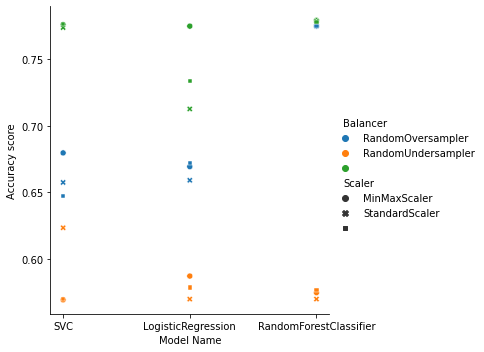

In [15]:
sns.relplot(data=df_classification, x="Model Name", y="Accuracy score", style="Scaler", hue="Balancer", kind="scatter")

In [1]:
write_pickle(path= os.path.join(base_path, clustering_path, class_path, model_path, f"{model_path}_classification_df.pkl"), obj=df_classification)

NameError: name 'write_pickle' is not defined